**skip gram basedm Word2Vec model**

In [4]:
import re
import numpy as np
np.random.seed(12)
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

**Example text**

In [5]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [6]:
def text_cleaning(text):
    "splitting the text up into smaller units like words, getting rid of punctuations"
    " output : list of words in the text"

    pattern  = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')

    return pattern.findall(text.lower())

In [7]:
clean_test =text_cleaning(text=text)
print(len(clean_test))

84


In [8]:
def lookup(tokens):
    """ Lookup table  which helps to convert words to indices and indices to words"""
    word_to_id = {}
    id_to_word = {}

    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i]= token

    return word_to_id, id_to_word

In [9]:
word_id ,id_word =lookup(tokens=clean_test)

In [10]:


def one_hot_encode(index, vocab_size):
    vec = np.zeros(vocab_size)
    vec[index] = 1
    return vec

def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        # left context
        left_context = range(max(0, i - window), i)
        # right context
        right_context = range(i + 1, min(n_tokens, i + window + 1))
        
        for j in list(left_context) + list(right_context):
            
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))   # center word
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))   # context word
    
    return np.asarray(X), np.asarray(y)


**Create the train and text data**

In [11]:
X, y = generate_training_data(clean_test, word_id, window=2)
print(X.shape)
print(y.shape)

(330, 60)
(330, 60)


Try to play with the window size to generate more data so that the words has beed placed  in vector space  

In [12]:
X[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
for xi, yi in zip(X, y):
    print(f"{np.argmax(xi)}, ->,{np.argmax(yi)}  : {id_word[np.argmax(xi)]} ->{id_word[np.argmax(yi)]} ")


36, ->,38  : machine ->learning 
36, ->,58  : machine ->is 
38, ->,36  : learning ->machine 
38, ->,58  : learning ->is 
38, ->,4  : learning ->the 
58, ->,36  : is ->machine 
58, ->,38  : is ->learning 
58, ->,4  : is ->the 
58, ->,18  : is ->study 
4, ->,38  : the ->learning 
4, ->,58  : the ->is 
4, ->,18  : the ->study 
4, ->,25  : the ->of 
18, ->,58  : study ->is 
18, ->,4  : study ->the 
18, ->,25  : study ->of 
18, ->,34  : study ->computer 
25, ->,4  : of ->the 
25, ->,18  : of ->study 
25, ->,34  : of ->computer 
25, ->,13  : of ->algorithms 
34, ->,18  : computer ->study 
34, ->,25  : computer ->of 
34, ->,13  : computer ->algorithms 
34, ->,8  : computer ->that 
13, ->,25  : algorithms ->of 
13, ->,34  : algorithms ->computer 
13, ->,8  : algorithms ->that 
13, ->,32  : algorithms ->improve 
8, ->,34  : that ->computer 
8, ->,13  : that ->algorithms 
8, ->,32  : that ->improve 
8, ->,28  : that ->automatically 
32, ->,13  : improve ->algorithms 
32, ->,8  : improve ->that 


**Buildig the Model**

summarize the entire process: 
    First, embeddings are simply the rows of the first weight matrix, denoted as W1
    . Through training and backpropgation, we adjust the weights of W1
    , along with the weight matrix in the second layer, denoted as W2
    , using cross entropy loss. Overall, our model takes on the following structure:

    A1=XW1
    A2=A1W2
    Z=softmax(A2)

where Z
 is the matrix contains the prediction probability vectors, X input 

In [14]:
def init_network(vocab_size,n_embedding):
    model = {
        "W1" : np.random.randn(vocab_size,n_embedding),  # W1 -> first weight matrix
        "W2" : np.random.randn(n_embedding,vocab_size)   # W2 --> second weight matrix
    }
    return model

In [15]:
model  = init_network(vocab_size=len(word_id),n_embedding=10)

In [16]:
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp/exp.sum())
    return res



def cross_entropy(z,y):
    return np.sum(np.log(z) * y)


In [17]:
def forward(model, X, return_cache=True):
    "This provide the forward  propagation network for the neural network"
    cache = {}
    cache["a1"] = X @ model["W1"]
    cache["a2"] = cache["a1"] @ model["W2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache

In [18]:
def backward(model, X, y, alpha):
    "this provid the back propagation  "
    " dimention of gradient must be equal to the dimention of original matrix"
    "alpha -> learnig rate "
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["W2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["W2"].shape)
    assert(dw1.shape == model["W1"].shape)
    model["W1"] -= alpha * dw1
    model["W2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

In [19]:
n_iter = 50
learning_rate =  0.05
history = [backward(model,X,y,learning_rate) for _ in range(n_iter)]


**Extract Word Embeddings**

In [20]:
embeddings = model["W1"]   # shape: (vocab_size, n_embedding)

# Example: get embedding for "machine"
machine_vec = embeddings[word_id["machine"]]
print("Machine vector:", machine_vec)


Machine vector: [ 0.08039     0.66424135  0.35088709 -0.66442022  1.87063263  1.01107249
  0.25339301  0.83897037 -0.68052614  0.43433559]


In [43]:
len(embeddings)

60

**Compare Word Similarity**

In [41]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(v1, v2):
    return dot(v1, v2) / (norm(v1) * norm(v2))

print("Similarity(machine, learning):",
      cosine_similarity(embeddings[word_id["study"]],
                        embeddings[word_id["computer"]]))


Similarity(machine, learning): 0.3787887666284575


**Visualize in 2D**

You can reduce embeddings with PCA/t-SNE:

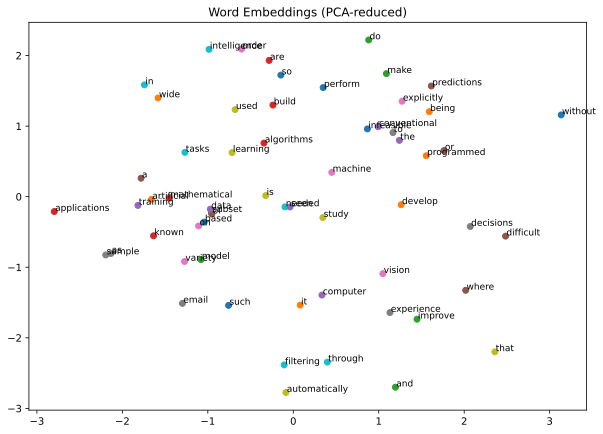

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(10,7))
for word, idx in word_id.items():
    x, y = reduced[idx]
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.title("Word Embeddings (PCA-reduced)")
plt.show()


In [23]:
learning =  one_hot_encode(word_id["learning"],len(word_id))
result  = forward(model,[learning], return_cache=False)[0]

In [24]:
learning = one_hot_encode(word_id["learning"], len(word_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
the
is
are
so
build
intelligence
of
develop
as
learning
that
or
subset
in
used
perform
known
such
variety
decisions
seen
difficult
algorithms
email
programmed
applications
filtering
training
make
explicitly
needed
through
where
a
wide
experience
automatically
study
order
artificial
data
conventional
do
and
it
computer
improve
without
to
tasks
predictions
model
on
sample
mathematical
vision
infeasible
being
based


In [25]:
model["W1"]

array([[ 1.21728712e+00, -2.07079827e+00, -4.24393877e-01,
        -7.70356596e-01,  1.13841507e+00, -1.42493625e+00,
         1.86133935e-01,  8.44906119e-01, -2.97752228e-01,
         1.70183526e+00],
       [-6.51604676e-01, -9.52076499e-01,  1.99032059e+00,
        -6.81369871e-01,  1.51095042e-01,  9.56893438e-01,
         1.07472725e+00, -1.30578450e+00, -4.24861658e-01,
        -4.19854255e-01],
       [ 6.61231511e-02,  6.32268436e-01, -5.38762239e-01,
         8.82744278e-01, -1.56103662e+00, -2.42955403e+00,
        -3.17596692e+00,  4.83163334e-01, -7.83465466e-01,
        -1.95567261e-01],
       [ 5.28925214e-01, -7.96126669e-01,  1.14724518e+00,
         1.41505890e+00, -2.23238030e+00, -2.86770168e-01,
        -1.67759639e-01, -7.53076445e-01, -4.28270992e-01,
        -1.39703173e+00],
       [-1.31484932e+00, -9.72407313e-01,  1.37097479e+00,
         6.43997576e-01,  1.13598877e+00,  7.39527674e-03,
         2.70719237e-01,  1.17741557e+00, -2.23689123e+00,
         9.

In [26]:
def get_embedding (model,word):
    try :
        idx = word_id[word]
    except KeyError:
        print('word not in the corpus')
    one_hot = one_hot_encode(idx,len(word_id))
    return forward(model,one_hot)["a1"]

In [27]:
get_embedding(model,"machine")

array([ 0.08039   ,  0.66424135,  0.35088709, -0.66442022,  1.87063263,
        1.01107249,  0.25339301,  0.83897037, -0.68052614,  0.43433559])

In [28]:
from numpy import dot
from numpy.linalg import norm

def cosine_sim(v1, v2):
    return dot(v1, v2) / (norm(v1) * norm(v2))


cosine_sim(get_embedding(model,"machine"),
           get_embedding(model,"learning"))


np.float64(0.08984289201658666)

In [29]:
cosine_sim(get_embedding(model,"machine"),
           get_embedding(model,"computer"))

np.float64(0.2559946945380506)

In [30]:
cosine_sim(get_embedding(model,"machine"),
           get_embedding(model,"applications"))

np.float64(-0.18319056984152202)

**One-Hot Encoding → Keras**

technically  we use one-hot encoding as input to Keras models — but in practice it is usually a bad idea for NLP, especially with large vocabularies. Let me break it down.

If you one-hot encode each word into a vector of size vocab_size, you can pass that directly into a Dense layer in Keras.

**sample keras model**

```
vocab_size = 5000   # suppose
model = Sequential([
    Input(shape=(vocab_size,)),
    Dense(128, activation="relu"),
    Dense(vocab_size, activation="softmax")
])
```

**Why people don’t use one-hot with Keras for NLP**

Huge dimensionality: If vocab_size = 50,000, every input vector is 50,000 long, but mostly zeros → memory waste + slow.

Dense connections: Each input neuron connects to every hidden neuron. If you had 50,000 × 300 hidden layer = 15 million weights just in first layer. Not scalable.

No semantic info: One-hot doesn’t capture similarity between words. (“king” and “queen” are just as unrelated as “king” and “banana”).

**Summary:**

One-hot can be used with Keras, but it’s inefficient.

Embedding layers are designed specifically to replace one-hot, reducing memory and computation while learning meaningful representations.